### Spike-and-slab prior

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/jl_files/zz_samplers.jl")

GibbsHMC (generic function with 3 methods)

In [2]:
d, Nobs = 20, 50
pX, pξ = 1e-1, 1e-1
X = sprandn(d, Nobs, pX)
X[1,:] = ones(Nobs)
ξ_true = sprandn(d,pξ)
ξ_true[1] = randn()
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] for j in 1:Nobs])
mb_size = 5
σ02 = 1

prior = SS_prior(d, σ02);

In [3]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

In [4]:
# Sub-sampling with weights and no CV

prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(0, Nobs, mb_size)

@showprogress for i in 2:d
    weights_het = abs.(X[i,:])./sum(abs.(X[i,:]))
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het, prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [5]:
A_xi = eye(d)
A_hyp = eye(hyperparam_size(prior))

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(10^6, 2*10^5)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

In [6]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [7]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e-1)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [8]:
start = time()
ZZ_block_sample(my_model, outp, blocksampler, mstate)
print("Total time: ", round((time()-start)/60, 2), " mins")

10 percent attempts in 0.42 min; zz bounces = 13878, hyp bounces = 77, total time of process = 767.016 
20 percent attempts in 0.81 min; zz bounces = 27801, hyp bounces = 154, total time of process = 1553.396 
Trimmed after 200000 bouncing attempts 
30 percent attempts in 1.22 min; zz bounces = 42223, hyp bounces = 245, total time of process = 2343.110 
40 percent attempts in 1.63 min; zz bounces = 56528, hyp bounces = 324, total time of process = 3144.178 
50 percent attempts in 2.04 min; zz bounces = 71336, hyp bounces = 407, total time of process = 3930.425 
60 percent attempts in 2.45 min; zz bounces = 86103, hyp bounces = 488, total time of process = 4713.686 
70 percent attempts in 2.88 min; zz bounces = 100708, hyp bounces = 565, total time of process = 5494.241 
80 percent attempts in 3.30 min; zz bounces = 114187, hyp bounces = 628, total time of process = 6299.783 
90 percent attempts in 3.72 min; zz bounces = 126855, hyp bounces = 717, total time of process = 7114.099 
100 p

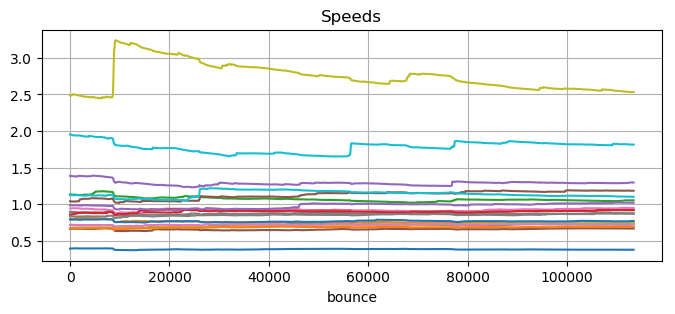

In [9]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

In [10]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

* Configuration temperature should be around 1.

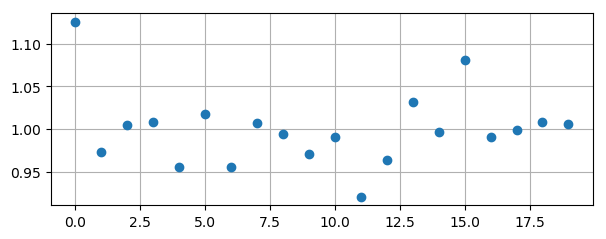

In [11]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)